<a href="https://colab.research.google.com/github/marquesarthur/vanilla-bert-vs-huggingface/blob/main/hugging_face_keras_bert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%matplotlib inline

Based on 



1.   https://towardsdatascience.com/hugging-face-transformers-fine-tuning-distilbert-for-binary-classification-tasks-490f1d192379
2.   https://www.analyticsvidhya.com/blog/2020/07/transfer-learning-for-nlp-fine-tuning-bert-for-text-classification/
3.   https://huggingface.co/transformers/training.html#fine-tuning-with-keras




**problem statement:**


*   a developer has to inspect an **artifact X**
*   Within the artifact, only a portion of the text is relevant to **input task Y**
*   We ought to build a model that establishes relationships between **Y** and **sentences x ∈ X** 
*  The model must determine: **is x relevant to task Y**




<br>

___

*Example of a task and an annotated artifact:*

<br>

[<img src="https://i.imgur.com/Zj1317H.jpg">](https://i.imgur.com/Zj1317H.jpg)




* The coloured sentences are sentences annotated as relevant to the input task. 
* The warmer the color, the more annotators selected that portion of the text. 
* For simplicity, we process the data and used sentences 

<br>

___

*Ultimately, our data is a tuple representing:*


*   **text** = artifact sentence

*   **question** = task description

*   **source** = URL of the artifact

*   **category_index** = whether sentence is relevant [or not] for the input task

*   **weights** = number of participants who annotated sentence as relevant


<br>

___



In [2]:
# @title Install dependencies

# !pip install transformers
# %tensorflow_version 2.x

In [3]:
# !pip install -q scikit-learn tqdm pandas python-Levenshtein path colorama

In [4]:
# @title Download git repo
# !git clone https://github.com/marquesarthur/vanilla-bert-vs-huggingface.git

In [5]:
# %cd vanilla-bert-vs-huggingface
# !git pull
# !ls -l

In [6]:
# @title Import data as JSON
import itertools
import json
import logging
import os
import sys
import random
from pathlib import Path

from Levenshtein import ratio
from colorama import Fore, Style

logger = logging.getLogger()
logger.level = logging.DEBUG
stream_handler = logging.StreamHandler(sys.stdout)
logger.addHandler(stream_handler)

from ds_android import get_input_for_BERT

raw_data = get_input_for_BERT()

print('Sample entry from data:')
print(json.dumps(raw_data[0], indent=4, sort_keys=True))

5 47  https://developer.android.com/reference/android/widget/ArrayAdapter
9 21  https://stackoverflow.com/questions/6442054
3 22  https://github.com/nostra13/Android-Universal-Image-Loader/issues/462
22 211  https://www.raywenderlich.com/155-android-listview-tutorial-with-kotlin
21 59  https://guides.codepath.com/android/Using-an-ArrayAdapter-with-ListView
6 33  https://github.com/realm/realm-java/issues/776
9 15  https://developer.android.com/training/volley/request
14 65  https://stackoverflow.com/questions/28504524
20 59  https://medium.com/@JasonCromer/android-asynctask-http-request-tutorial-6b429d833e28
5 97  https://www.twilio.com/blog/5-ways-to-make-http-requests-in-java
17 33  https://developer.android.com/guide/navigation/navigation-custom-back
6 55  https://stackoverflow.com/questions/10108774
5 470  https://developer.android.com/reference/android/widget/TextView
7 11  https://stackoverflow.com/questions/19025301
3 17  https://stackoverflow.com/questions/8712652
8 59  https:/

22 104  https://developer.android.com/reference/org/json/JSONObject
8 31  https://guides.codepath.com/android/converting-json-to-models
5 34  https://developer.android.com/guide/topics/media-apps/volume-and-earphones
4 40  https://developer.android.com/training/gestures/scale
6 32  https://stackoverflow.com/questions/10630373
Sample entry from data:
{
    "category_index": 0,
    "question": "Explanation of the getView() method of an ArrayAdapter",
    "source": "https://developer.android.com/reference/android/widget/ArrayAdapter",
    "text": "public class ArrayAdapter extends BaseAdapter implements Filterable, ThemedSpinnerAdapter",
    "weights": 0
}


In [7]:
from collections import Counter, defaultdict

cnt = Counter([d['category_index'] for d in raw_data])

total = sum(cnt.values())

labels_cnt = [cnt[0] / float(total), cnt[1] / float(total)]
print('label distribution')
print('')
print('not-relevant -- {:.0f}%'.format(labels_cnt[0] * 100))
print('RELEVANT ------ {:.0f}%'.format(labels_cnt[1] * 100))

label distribution

not-relevant -- 88%
RELEVANT ------ 12%


In [8]:
seframes = {}
with open('seframes.json') as input_file:
    seframes = json.load(input_file)

In [9]:
def has_meaningful_frame(text):    
    meaning_frames = [
        'Temporal_collocation', 'Execution', 'Using', 'Intentionally_act',
        'Being_obligated', 'Likelihood', 'Causation', 'Required_event',
        'Desiring', 'Awareness', 'Grasp', 'Attempt'
    ]
    
    if text in seframes:
        text_labels = seframes[text]
        if any([elem in meaning_frames for elem in text_labels]):
            return True
        
    return False

In [10]:
# @title Set environment variables

model_id = 'bert-base-uncased'
# model_id = 'distilbert-base-uncased'

import os
import contextlib
import tensorflow as tf
import os
import codecs
import numpy as np
import math
import json

import numpy as np
import pandas as pd

from collections import defaultdict, Counter
from tqdm import tqdm

USE_TPU = False
os.environ['TF_KERAS'] = '1'

# @title Initialize TPU Strategy
if USE_TPU:
    TPU_WORKER = 'grpc://' + os.environ['COLAB_TPU_ADDR']
    resolver = tf.contrib.cluster_resolver.TPUClusterResolver(TPU_WORKER)
    tf.contrib.distribute.initialize_tpu_system(resolver)
    strategy = tf.contrib.distribute.TPUStrategy(resolver)

# sklearn libs
import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report

# Tensorflow Imports
import tensorflow as tf
from tensorflow.python import keras
import tensorflow.keras.backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import initializers


# Hugging face imports
from transformers import AutoTokenizer
from transformers import TFDistilBertForSequenceClassification, TFBertForSequenceClassification
from transformers import TFDistilBertModel, DistilBertConfig
from transformers import DistilBertTokenizerFast, BertTokenizerFast




Falling back to TensorFlow client; we recommended you install the Cloud TPU client directly with pip install cloud-tpu-client.


In [11]:

# Bert Model Constants
SEQ_LEN = 64 # 128
BATCH_SIZE = 64 # 64 32 larger batch size causes OOM errors
EPOCHS = 10 # 3 4
LR = 1e-5 # 2e-5

# 3e-4, 1e-4, 5e-5, 3e-5
# My own constants
# USE_FRAME_FILTERING = False
# UNDERSAMPLING = True
# N_UNDERSAMPLING = 2 # ratio of how many samples from 0-class, to 1-class, e.g.: 2:1
# USE_DS_SYNTHETIC = False

USE_FRAME_FILTERING = False
UNDERSAMPLING = True
N_UNDERSAMPLING = 1 # ratio of how many samples from 0-class, to 1-class, e.g.: 2:1
USE_DS_SYNTHETIC = True
MIN_W = 3

In [12]:
# @title JSON to dataframe helper functions
def undersample_df(df, n_times=3):
    class_0,class_1 = df.category_index.value_counts()
    c0 = df[df['category_index'] == 0]
    c1 = df[df['category_index'] == 1]
    df_0 = c0.sample(int(n_times * class_1))
    
    undersampled_df = pd.concat([df_0, c1],axis=0)
    return undersampled_df

def get_ds_synthetic_data(min_w=MIN_W):
    short_task = {
      "bugzilla": """How to query bugs using the custom fields with the Bugzilla REST API?""",
      "databases": """Which technology should be adopted for the database layer abstraction: Object/Relational Mapping (ORM) or a Java Database Connectivity API (JDBC)?""",
      "gpmdpu": """Can I bind the cmd key to the GPMDPU shortcuts?""",
      "lucene": """How does Lucene compute similarity scores for the BM25 similarity?""",
      "networking": """Which technology should be adopted for the notification system, Server-Sent Events (SSE) or WebSockets?""",
    }

    with open('relevance_corpus.json') as ipf:
        aux = json.load(ipf)
        raw_data = defaultdict(list)
        for d in aux:
            if d['task'] == 'yargs':
                continue

            raw_data['text'].append(d['text'])
            raw_data['question'].append(short_task[d['task']])
            raw_data['source'].append(d['source'])
            raw_data['category_index'].append(1 if d['weight'] > min_w else 0)
            raw_data['weights'].append(d['weight'] if d['weight'] > min_w else 0)
 
        data = pd.DataFrame.from_dict(raw_data)
        data = undersample_df(data, n_times=1)
        data = data.sample(frac=1).reset_index(drop=True)
      
    return data

def get_class_weights(y, smooth_factor=0, upper_bound=5.0):
    """
    Returns the weights for each class based on the frequencies of the samples
    :param smooth_factor: factor that smooths extremely uneven weights
    :param y: list of true labels (the labels must be hashable)
    :return: dictionary with the weight for each class
    """
    counter = Counter(y)

    if smooth_factor > 0:
        p = max(counter.values()) * smooth_factor
        for k in counter.keys():
            counter[k] += p

    majority = max(counter.values())

    clazz = {cls: float(majority / count) for cls, count in counter.items()}
    result = {}
    for key, value in clazz.items():
        if value > upper_bound:
            value = upper_bound
        
        result[key] = value
    return result

def add_raw_data(result, data):
    result['text'].append(data['text'])
    result['question'].append(data['question'])
    result['source'].append(data['source'])
    result['category_index'].append(data['category_index'])
    result['weights'].append(data['weights'])


In [13]:
# @title Tokenizer

print(model_id)
if model_id == 'distilbert-base-uncased':
    tokenizer = DistilBertTokenizerFast.from_pretrained(model_id)
else:
    tokenizer = BertTokenizerFast.from_pretrained(model_id)

bert-base-uncased
Starting new HTTPS connection (1): huggingface.co:443
https://huggingface.co:443 "HEAD /bert-base-uncased/resolve/main/vocab.txt HTTP/1.1" 200 0
Starting new HTTPS connection (1): huggingface.co:443
https://huggingface.co:443 "HEAD /bert-base-uncased/resolve/main/tokenizer.json HTTP/1.1" 200 0
Starting new HTTPS connection (1): huggingface.co:443
https://huggingface.co:443 "HEAD /bert-base-uncased/resolve/main/added_tokens.json HTTP/1.1" 404 0
Starting new HTTPS connection (1): huggingface.co:443
https://huggingface.co:443 "HEAD /bert-base-uncased/resolve/main/special_tokens_map.json HTTP/1.1" 404 0
Starting new HTTPS connection (1): huggingface.co:443
https://huggingface.co:443 "HEAD /bert-base-uncased/resolve/main/tokenizer_config.json HTTP/1.1" 200 0


In [14]:
# @title data encoder

def _encode(tokenizer, dataframe, max_length=SEQ_LEN):
    
    seq_a = dataframe['text'].tolist()
    seq_b = dataframe['question'].tolist()
    
    return tokenizer(seq_a, seq_b, truncation=True, padding=True, max_length=max_length)

def to_one_hot_encoding(data, nb_classes = 2):
    targets = np.array([data]).reshape(-1)
    one_hot_targets = np.eye(nb_classes)[targets]
    return one_hot_targets    

In [15]:
# @title Metrics & Logging functions

from sklearn.metrics import classification_report

recommendation_metrics = defaultdict(list)
prediction_metrics = defaultdict(list)

classification_report_lst = []
log_examples_lst = []
source_lst = []

def aggregate_macro_metrics(store_at, precision, recall, fscore):   
    store_at['precision'].append(precision)
    store_at['recall'].append(recall)
    store_at['fscore'].append(fscore)

def aggregate_recommendation_metrics(store_at, k, precision_at_k, pyramid_precision_at_k):
    store_at['k'].append(k)
    store_at['precision'].append(precision_at_k)
    store_at['∆ precision'].append(pyramid_precision_at_k)
    
def aggregate_report_metrics(clz_report):
    relevant_label = str(1)
    if relevant_label in clz_report:
        for _key in ['precision', 'recall']:
            if _key in clz_report[relevant_label]:
                clz_report_lst[_key].append(clz_report[relevant_label][_key])    
                
def log_examples(task_title, source, text, pweights, y_predict, y_probs, k=10):
    # get the predicted prob at every index
    idx_probs = [(idx, y_predict[idx], y_probs[idx]) for idx, _ in enumerate(y_predict)]
    
    # filter probs for all indexes predicted as relevant  
    idx_probs = list(filter(lambda k: k[1] == 1, idx_probs))
    
    most_probable = sorted(idx_probs, key=lambda i: i[2], reverse=True)
    
    result = [idx for idx, _, _ in most_probable][:k]
    
    for idx in result:
        log_examples_lst.append((
            source, 
            task_title,
            pweights[idx],
            y_predict[idx],
            y_probs[idx],
            text[idx]
        ))

def _precision_at_k(y_test, y_predict, y_prob, k=10):
    # get the predicted prob at every index
    idx_probs = [(idx, y_predict[idx], y_prob[idx]) for idx, _ in enumerate(y_test)]
    
    # filter probs for all indexes predicted as relevant  
    idx_probs = list(filter(lambda k: k[1] == 1, idx_probs))
    
    most_probable = sorted(idx_probs, key=lambda i: i[2], reverse=True)
    result = [y_test[idx] * y_predict[idx] for idx, _, _ in most_probable]   
    y_predict = [y for _, y, _ in most_probable]
    
    result = result[:k]
    y_predict = y_predict[:k]
    ratio = sum(result) / float(len(y_predict) + 0.00001)
    return ratio     


def _pyramid_score(y_optimal, y_predicted, y_prob, k=10):

    # create reference table for weights 
    # y_predicted = [i for i in y_optimal]
    # get the predicted prob at every index
    idx_probs = [(idx, y_optimal[idx], y_predicted[idx], y_prob[idx]) for idx, _ in enumerate(y_optimal)]
    
    # filter probs for all indexes predicted as relevant  
    idx_probs = list(filter(lambda aux: aux[2] == 1, idx_probs))

    # sort
    most_probable = sorted(idx_probs, key=lambda i: i[3], reverse=True)

    # compute predicted and optimal score up until K
    predicted_score = [w for _, w, _, _ in most_probable][:k]
    optimal_score = sorted(y_optimal, reverse=True)[:k]
    
    ratio = sum(predicted_score) / float(sum(optimal_score) + 0.00001)
    return ratio           

In [16]:
#@title Training procedures

def get_train_val_test(task_uid, size=0.9, undersample=False, aug=True, undersample_n=3):
    if not isinstance(task_uid, list):
        task_uid = [task_uid]
        
    train_data_raw = defaultdict(list)
    test_data_raw = defaultdict(list)
    
    for _data in tqdm(CORPUS):
        if _data['question'] in task_uid:
            add_raw_data(test_data_raw, _data)
        else:
            add_raw_data(train_data_raw, _data)
    
    train_val = pd.DataFrame.from_dict(train_data_raw)
    test = pd.DataFrame.from_dict(test_data_raw)
    
    # https://stackoverflow.com/questions/29576430/shuffle-dataframe-rows
    #  randomize rows....    
    train_val = train_val.sample(frac=1).reset_index(drop=True)
    test = test.sample(frac=1).reset_index(drop=True)
    
    if undersample:
        train_val = undersample_df(train_val, n_times=undersample_n)
        train_val = train_val.sample(frac=1).reset_index(drop=True)
        
    if aug:
        train_val = pd.concat([train_val, get_ds_synthetic_data()],axis=0)
        train_val = train_val.sample(frac=1).reset_index(drop=True)
    
    weights = get_class_weights(train_val['category_index'].tolist())
    
    train, val = train_test_split(
        train_val, 
        stratify=train_val['category_index'].tolist(), 
        train_size=size
    )
    
    return train, val, test, weights        

In [17]:
def update_predictions(task_title, text, y_predict, y_probs, relevant_class=1):
    result = []
    
    for _t, _y, _prob in zip(text, y_predict, y_probs):
        if _y == relevant_class:
            if has_meaningful_frame(_t):
                result.append(_y)
            else:
                result.append(0)
        else:
            result.append(_y)
    
    return result    

In [18]:
# @title Testing procedures

# https://medium.com/geekculture/hugging-face-distilbert-tensorflow-for-custom-text-classification-1ad4a49e26a7
def eval_model(model, test_data):
    preds = model.predict(test_data.batch(1)).logits  
    
    #transform to array with probabilities
    res = tf.nn.softmax(preds, axis=1).numpy()      

    return res.argmax(axis=-1), res[:, 1]

def test_model(source, df_test, model, tokenizer, pos_filter=False):
    
    df_source = df_test[df_test["source"] == source]   
    task_title = df_source['question'].tolist()[0]
    text = df_source['text'].tolist()
    pweights = df_source['weights'].tolist()
    
    # Encode X_test
    test_encodings = _encode(tokenizer, df_source)
    test_labels = df_source['category_index'].tolist()
    
    test_dataset = tf.data.Dataset.from_tensor_slices((
        dict(test_encodings),
        test_labels
    ))
    
    y_true = [y.numpy() for x, y in test_dataset]
    y_predict, y_probs = eval_model(model, test_dataset)
    
    if pos_filter:
        y_predict = update_predictions(task_title, text, y_predict, y_probs)
    

    accuracy = accuracy_score(y_true, y_predict)
    macro_f1 = f1_score(y_true, y_predict, average='macro')
    
    classification_report_lst.append(classification_report(y_true, y_predict))
    aggregate_report_metrics(classification_report(y_true, y_predict, output_dict=True))

    logger.info("-" * 20)    
    
    logger.info("Y")
    logger.info("[0s] {} [1s] {}".format(
        len(list(filter(lambda k: k== 0, y_true))),
        len(list(filter(lambda k: k== 1, y_true)))
    ))
    
        
    logger.info("predicted")
    logger.info("[0s] {} [1s] {}".format(
        len(list(filter(lambda k: k== 0, y_predict))),
        len(list(filter(lambda k: k== 1, y_predict)))
    ))
    
    logger.info("-" * 20)
    
    logger.info("Accuracy: {:.4f}".format(accuracy))
    logger.info("macro_f1: {:.4f}".format(macro_f1))

    precision, recall, fscore, _ = precision_recall_fscore_support(y_true, y_predict, average='macro')
    
    aggregate_macro_metrics(prediction_metrics, precision, recall, fscore)
    
    logger.info("Precision: {:.4f}".format(precision))
    logger.info("Recall: {:.4f}".format(recall))
    logger.info("F1: {:.4f}".format(fscore))
    
    logger.info("-" * 20)
    
    for k in [3, 5, 10]:
        p_at_k = _precision_at_k(y_true, y_predict, y_probs, k=k)
        score_at_k = 0.0 #_pyramid_score(pweights, y_predict, y_probs, k=k)
                                     
        aggregate_recommendation_metrics(recommendation_metrics, k, p_at_k, score_at_k)
        
        logger.info("")
        logger.info("Precision_at_{}: {:.4f}".format(k, p_at_k))
        logger.info("Pyramid_at_{}: {:.4f}".format(k, score_at_k))
    logger.info("-" * 20)
    
    log_examples(task_title, source, text, pweights, y_predict, y_probs, k=10)
    source_lst.append(source)

In [19]:
# @title 10-fold cross validation WIP
CORPUS = raw_data

all_tasks = sorted(list(set([d['question'] for d in raw_data])))
rseed = 20210343
random.seed(rseed)
random.shuffle(all_tasks)

from sklearn.model_selection import KFold


recommendation_metrics = defaultdict(list)
prediction_metrics = defaultdict(list)
random_prediction_metrics = defaultdict(list)
clz_report_lst = defaultdict(list)

classification_report_lst = []
log_examples_lst = []
source_lst = []


n_splits = 10
kf = KFold(n_splits=n_splits, random_state=rseed)
np_tasks_arr = np.array(all_tasks)

idx_split = 0
for train_index, test_index in kf.split(np_tasks_arr):    
    test_tasks_lst = np_tasks_arr[test_index].tolist()
    
    logger.info("")
    logger.info(Fore.RED + f"Fold {idx_split}" + Style.RESET_ALL)
    logger.info('\n'.join(test_tasks_lst))
    
    # <------------------------------------------------------------------------- INPUT
    df_train, df_val, df_test, weights = get_train_val_test(
        test_tasks_lst,
        aug=USE_DS_SYNTHETIC,
        undersample=UNDERSAMPLING, 
        undersample_n=N_UNDERSAMPLING
    )
    # <------------------------------------------------------------------------- INPUT

    logger.info('-' * 10)
    logger.info(Fore.RED + 'train'+ Style.RESET_ALL)
    logger.info(str(df_train.category_index.value_counts()))
    logger.info("")
    
    logger.info(Fore.RED + 'test'+ Style.RESET_ALL)
    logger.info(str(df_test.category_index.value_counts()))
    logger.info("")

    logger.info(Fore.RED + 'weights'+ Style.RESET_ALL)
    logger.info(str(weights))
    logger.info('-' * 10)
    
    
    # Encode X_train
    train_encodings = _encode(tokenizer, df_train)
    train_labels = df_train['category_index'].tolist()

    # Encode X_valid
    val_encodings = _encode(tokenizer, df_val)
    val_labels = df_val['category_index'].tolist()


    # https://huggingface.co/transformers/custom_datasets.html
    train_dataset = tf.data.Dataset.from_tensor_slices((
        dict(train_encodings),
        train_labels
    ))

    val_dataset = tf.data.Dataset.from_tensor_slices((
        dict(val_encodings),
        val_labels
    ))

    
    if model_id == 'distilbert-base-uncased':
        model = TFDistilBertForSequenceClassification.from_pretrained(model_id)
    else:
        model = TFBertForSequenceClassification.from_pretrained(model_id)

    # freeze all the parameters
    # for param in model.parameters():
    #   param.requires_grad = False
        

    optimizer = tf.keras.optimizers.Adam(learning_rate=LR)
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

    METRICS = [
        tf.keras.metrics.SparseCategoricalAccuracy()
    ]

    model.compile(
        optimizer=optimizer,
        loss=loss_fn,
        metrics=METRICS
    )

    # https://discuss.huggingface.co/t/how-to-dealing-with-data-imbalance/393/3
    model.fit(
        train_dataset.shuffle(1000).batch(BATCH_SIZE), 
        epochs=EPOCHS, 
        batch_size=BATCH_SIZE,
        class_weight=weights,
        validation_data=val_dataset.shuffle(1000).batch(BATCH_SIZE)
    )
    
    logger.info("")
    logger.info(Fore.RED + f"Testing model" + Style.RESET_ALL)
    for source in df_test["source"].unique():
        df_source = df_test[df_test["source"] == source]   
        logger.info(source)
        test_model(source, df_source, model, tokenizer, pos_filter=USE_FRAME_FILTERING)
            
    idx_split += 1
    
    if idx_split >= 2:
        break
#     break    


Fold 0
how can i get the value of text view in recyclerview item?
Hide MarkerView when nothing selected
How to check programmatically whether app is running in debug mode or not?
JSONObject parse dictionary objects
Want to add drawable icons insteadof colorful dots


/home/msarthur/hface/lib/python3.7/site-packages/sklearn/model_selection/_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
100%|██████████| 7931/7931 [00:00<00:00, 750226.09it/s]


----------
train
1    987
0    987
Name: category_index, dtype: int64

test
0    664
1     71
Name: category_index, dtype: int64

weights
{1: 1.0, 0: 1.0}
----------
Starting new HTTPS connection (1): huggingface.co:443
https://huggingface.co:443 "HEAD /bert-base-uncased/resolve/main/config.json HTTP/1.1" 200 0
Starting new HTTPS connection (1): huggingface.co:443
https://huggingface.co:443 "HEAD /bert-base-uncased/resolve/main/tf_model.h5 HTTP/1.1" 302 0


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10
The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
AutoGraph could not transform <bound method Socket.send of <zmq.sugar.socket.Socket object at 0x2b2e279dc910>> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expe

--------------------
Y
[0s] 8 [1s] 4
predicted
[0s] 8 [1s] 4
--------------------
Accuracy: 0.6667
macro_f1: 0.6250
Precision: 0.6250
Recall: 0.6250
F1: 0.6250
--------------------

Precision_at_3: 0.6667
Pyramid_at_3: 0.0000

Precision_at_5: 0.5000
Pyramid_at_5: 0.0000

Precision_at_10: 0.5000
Pyramid_at_10: 0.0000
--------------------

Fold 1
 height must be > 0
Write and Read a json data to internal storage android
Android PDF Rendering
How can I hide a fragment on start of my MainActivity( or the application)?
polymorphic deserialization of JSON with jackson, property type becomes &quot;null&quot;


100%|██████████| 7931/7931 [00:00<00:00, 400050.81it/s]

----------
train
1    963
0    963
Name: category_index, dtype: int64

test
0    675
1     98
Name: category_index, dtype: int64

weights


{1: 1.0, 0: 1.0}
----------
Starting new HTTPS connection (1): huggingface.co:443
https://huggingface.co:443 "HEAD /bert-base-uncased/resolve/main/config.json HTTP/1.1" 200 0
Starting new HTTPS connection (1): huggingface.co:443
https://huggingface.co:443 "HEAD /bert-base-uncased/resolve/main/tf_model.h5 HTTP/1.1" 302 0


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10
The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.
The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.
31/31 [==============================] - ETA: 0s - loss: 0.6923 - sparse_categorical_accuracy: 0.5291The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output

F1: 0.6308
--------------------

Precision_at_3: 0.0000
Pyramid_at_3: 0.0000

Precision_at_5: 0.2000
Pyramid_at_5: 0.0000

Precision_at_10: 0.3750
Pyramid_at_10: 0.0000
--------------------
https://stackoverflow.com/questions/38980595
--------------------
Y
[0s] 2 [1s] 3
predicted
[0s] 5 [1s] 0
--------------------
Accuracy: 0.4000
macro_f1: 0.2857
Precision: 0.2000
Recall: 0.5000
F1: 0.2857
--------------------

Precision_at_3: 0.0000
Pyramid_at_3: 0.0000

Precision_at_5: 0.0000
Pyramid_at_5: 0.0000

Precision_at_10: 0.0000
Pyramid_at_10: 0.0000
--------------------
https://medium.com/@david.truong510/jackson-polymorphic-deserialization-91426e39b96a


/home/msarthur/hface/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------
Y
[0s] 11 [1s] 5
predicted
[0s] 3 [1s] 13
--------------------
Accuracy: 0.5000
macro_f1: 0.4921
Precision: 0.6923
Recall: 0.6364
F1: 0.4921
--------------------

Precision_at_3: 0.6667
Pyramid_at_3: 0.0000

Precision_at_5: 0.6000
Pyramid_at_5: 0.0000

Precision_at_10: 0.5000
Pyramid_at_10: 0.0000
--------------------


In [20]:
# for source in df_test["source"].unique():
#     df_source = df_test[df_test["source"] == source]   
#     logger.info(source)
#     test_model(source, df_source, model, tokenizer, pos_filter=True)

In [35]:
#@title Metrics report
def avg_recommendation_metric_for(data, k=3, filter_outliers=True):
    __precision = []
    __pyramid = []
    
    total_len = len(data['k'])
    
    for idx in range(total_len):
        
        __value = data['k'][idx]
        if __value  == k:
            if filter_outliers:            
                if data['precision'][idx] > 0.:
                    __precision.append(data['precision'][idx])
                if data['∆ precision'][idx] > 0.:
                    __pyramid.append(data['∆ precision'][idx])
            else:
                __precision.append(data['precision'][idx])
                __pyramid.append(data['∆ precision'][idx])
                
    r__precision = 0.
    if __precision:
        r__precision = np.mean(__precision)

    r__pyramid = 0.
    if __pyramid:
        r__pyramid = np.mean(__pyramid)

    return r__precision, r__pyramid

def avg_macro_metric_for(data):
    __precision = data['precision']
    __recall = data['recall']
    __fscore = data['fscore']

    return np.mean(__precision), np.mean(__recall), np.mean(__fscore)    

In [34]:
_precision, __pyramid_score = avg_recommendation_metric_for(
    recommendation_metrics, 
    k=3
)

logger.info(Fore.YELLOW + "k=3" + Style.RESET_ALL)
logger.info("precision: " + Fore.RED + "{:.3f}".format(_precision) + Style.RESET_ALL)

k=3
precision: 0.318


In [23]:
_precision, _recall, _f1score = avg_macro_metric_for(prediction_metrics)

logger.info("")
logger.info(Fore.YELLOW + "Model metrics" + Style.RESET_ALL)
logger.info("precision: " + Fore.RED + "{:.3f}".format(_precision) + Style.RESET_ALL)
logger.info("recall:    " + Fore.RED + "{:.3f}".format(_recall) + Style.RESET_ALL)
logger.info("f1-score:  " + Fore.RED + "{:.3f}".format(_f1score) + Style.RESET_ALL)


Model metrics
precision: 0.588
recall:    0.643
f1-score:  0.534


In [24]:
def examples_per_source_type(source_type='misc', n_samples=None):
    _sources = list(set([x[0] for x in log_examples_lst]))

    _template = "[w={}]" + Fore.RED + "[y={}]" + Fore.YELLOW + "[p={:.4f}]" + Style.RESET_ALL + " {}"

    idx = 0
    for s in _sources:
        examples_in_source = []
        if source_type == 'api' and ('docs.oracle' in s or 'developer.android' in s):
            examples_in_source = list(filter(lambda k: k[0] == s, log_examples_lst))
            task_title = examples_in_source[0][1]
            idx += 1
        elif source_type == 'so' and ('stackoverflow.com' in s):
            examples_in_source = list(filter(lambda k: k[0] == s, log_examples_lst))
            task_title = examples_in_source[0][1]            
            idx += 1
        elif source_type == 'git' and ('github.com' in s):
            examples_in_source = list(filter(lambda k: k[0] == s, log_examples_lst))
            task_title = examples_in_source[0][1]
            idx += 1
        elif source_type == 'misc' and 'github.com' not in s and 'docs.oracle' not in s and 'developer.android' not in s and 'stackoverflow.com' not in s:
            examples_in_source = list(filter(lambda k: k[0] == s, log_examples_lst))
            task_title = examples_in_source[0][1]
            idx += 1
        if not examples_in_source:
            continue
        logger.info('')
        logger.info(Fore.RED + f"{task_title}" + Style.RESET_ALL)    
        logger.info(s)
        logger.info('')

        for _, _, pweights, y_predict, y_probs, text in examples_in_source:
            logger.info(_template.format(pweights, y_predict, y_probs, text))
            logger.info('')
        logger.info('-' * 20)
      
        if n_samples and idx >= n_samples:
            break
    

In [25]:
#@title Sample prediction outputs for API sources

logger.info(Fore.RED + "API" + Style.RESET_ALL)
examples_per_source_type(source_type='api', n_samples=8)

API

how can i get the value of text view in recyclerview item?
https://developer.android.com/codelabs/basic-android-kotlin-training-recyclerview-scrollable-list

[w=0][y=1][p=0.9892] In this case, you need an adapter that takes an Affirmation instance from the list returned by loadAffirmations ( ), and turns it into a list item view, so that it can be displayed in the RecyclerView.

[w=0][y=1][p=0.9882] The last method you need to override is onBindViewHolder ( ).

[w=0][y=1][p=0.9876] In onCreateViewHolder ( ), return a new ItemViewHolder instance where the root view is adapterLayout.

[w=0][y=1][p=0.9865] RecyclerView supports displaying items in different ways, such as a linear list or a grid.

[w=0][y=1][p=0.9859] The resulting string can be set as the text of the textView in the holder ItemViewHolder.

[w=0][y=1][p=0.9858] Create a Datasource, call loadAffirmations ( ), get the size of the returned list, convert it to a string, and assign it as the text of textView.

[w=0][y=1][p


[w=0][y=1][p=0.8945] In that case, the new bounds of this Rectangle will have a location equal to the coordinates of the specified Point and width and height equal to zero.

[w=0][y=1][p=0.8678] The values stored into the width and height dimension fields will be chosen as the 32-bit values that encompass the largest part of the true result as possible.

[w=0][y=1][p=0.8631] A Rectangle whose width or height is negative has neither location nor dimension along those axes with negative dimensions.

[w=0][y=1][p=0.8535] If a point is not inside the shape, then it might still be contained in the bounds object:

[w=1][y=1][p=0.8174] A Rectangle object's width and height are public fields.

--------------------


In [26]:
#@title Sample prediction outputs for GIT sources

logger.info(Fore.RED + "GIT" + Style.RESET_ALL)
examples_per_source_type(source_type='git', n_samples=8)

GIT

Want to add drawable icons insteadof colorful dots
https://github.com/SundeepK/CompactCalendarView/issues/181

[w=0][y=1][p=0.9810] You will need to load your icon probably in the init ( ) method of that class and draw using the that bitmap method.

[w=0][y=1][p=0.9796] You can tweak the code on how you want to draw the icons:

[w=1][y=1][p=0.9772] There is a simple method call in android to go from pixels to dp.

[w=2][y=1][p=0.9686] Since you want to offset the icon to the top right, you will need to offset the ( x, y ) position slightly, but make sure you use dp because if you simply offset the ( x, y ) by some amount it willnot translate to different devices.

[w=3][y=1][p=0.9658] with some custome code which simply draws a drawable icon.

[w=0][y=1][p=0.9655] Also if you have more than one event for a given day, you only need to draw the icon once, then exit.

[w=0][y=1][p=0.9647] Then change CompactCalendarController.java by removing those lines I mentioned and replacing wit

In [27]:
#@title Sample prediction outputs for SO sources

logger.info(Fore.RED + "SO" + Style.RESET_ALL)
examples_per_source_type(source_type='so', n_samples=8)

SO

polymorphic deserialization of JSON with jackson, property type becomes &quot;null&quot;
https://stackoverflow.com/questions/30362446

[w=0][y=1][p=0.9935] Handling polymorphism is either model-bound or requires lots of code with various custom deserializers.

[w=0][y=1][p=0.9927] A simple way to enable polymorphic serialization / deserialization via Jackson library is to globally configure the Jackson object mapper -LRB- jackson.databind.ObjectMapper -RRB- to add information, such as the concrete class type, for certain kinds of classes, such as abstract classes.

[w=0][y=1][p=0.9918] You need only one line before the declaration of the class Animal for correct polymorphic serialization/deserialization:

[w=0][y=1][p=0.9903] It is useful for the cases when you have no way to change the incoming json or must not do so.

[w=0][y=1][p=0.9898] Option 1: Support polymorphic serialization / deserialization for abstract classes -LRB- and Object typed classes -RRB-

[w=0][y=1][p=0.9892] O

In [28]:
#@title Sample prediction outputs for MISC sources

logger.info(Fore.RED + "MISC" + Style.RESET_ALL)
examples_per_source_type(source_type='misc', n_samples=8)

MISC

how can i get the value of text view in recyclerview item?
https://guides.codepath.com/android/using-the-recyclerview

[w=0][y=1][p=0.9866] Instead of overriding the getItemsCount ( ), remove it since the size of the list will be managed by the ListAdapter class:

[w=0][y=1][p=0.9859] You can access the currently `` snapped'' item position with snappyRecyclerView.getFirstVisibleItemPosition ( ).

[w=1][y=1][p=0.9851] However, with a RecyclerView the adapter requires the existence of a `` ViewHolder'' object which describes and provides access to all the views within each item row.

[w=0][y=1][p=0.9836] ItemAnimator RecyclerView.ItemAnimator will animate ViewGroup modifications such as add/delete/select that are notified to the adapter.

[w=0][y=1][p=0.9833] Unlike the ListView adapter, a RecyclerView adapter should not rely on notifyDataSetChanged ( ) since the more granular actions should be used.

[w=0][y=1][p=0.9815] Heterogeneous Views See this guide if you want to inflate mu


[w=1][y=1][p=0.9856] and then you can use the FragmentManager to create a FragmentTransaction which allows us to add fragments to the FrameLayout at runtime:

[w=1][y=1][p=0.9850] In this case, you want to add a `` placeholder'' container ( usually a FrameLayout ) to your activity where the fragment is inserted at runtime:

[w=0][y=1][p=0.9836] A common pattern is to create a static newInstance method for creating a Fragment with arguments.

[w=0][y=1][p=0.9835] You can not replace a fragment defined statically in the layout file via a FragmentTransaction.

[w=1][y=1][p=0.9827] If the fragment should always be within the activity, use XML to statically add the fragment but in more complex cases be sure to use the Java-based approach.

--------------------


In [29]:
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")

Loaded backend module://ipykernel.pylab.backend_inline version unknown.


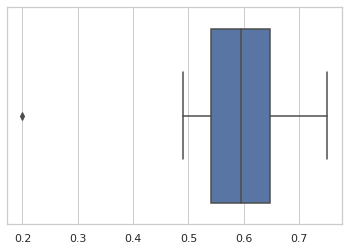

In [36]:
ax = sns.boxplot(x=prediction_metrics['precision'])

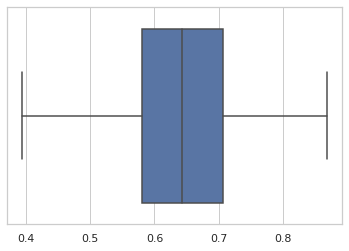

In [31]:
ax = sns.boxplot(x=prediction_metrics['recall'])